# A2.1 Regresión logística y validación cruzada

#### Para esta actividad, se trabajará con las mismas características del proyecto del primer parcial extraídas de una selección hacia atrás. La variable de sálida es PM2,5., la cual se binarizará para determinar del conjunto de datos, cual es la probabilidad de registrar un valor que es dañino para la salud, es decir, la probabilidad de registrar un valor igual o mayor que 35.5, punto en el que las personas con dificultades respiratorias empiezan a estar en riesgo.

In [9]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

#### 1. Se empieza por importar los datos del anterior proyecto, y se aplica el mismo proceso de filtración, separación en dos columnas para fecha y hora, así como la selección de características, y la aplicación del método Tukey para permanecer con los datos que son estadísticamente relevantes.

In [10]:
data = pd.read_excel("SOLICITUD_289-24_septiembre.xlsx")

In [11]:
data_filled = data.apply(lambda x: x.fillna(x.mean()), axis=0)
nan_percentage = data_filled.isna().mean() * 100
data_filled['Fecha y hora'] = pd.to_datetime(data_filled['Fecha y hora'], format='%m/%d/%Y %I:%M:%S %p')
data_filled['Fecha'] = data_filled['Fecha y hora'].dt.date
data_filled['Hora'] = data_filled['Fecha y hora'].dt.time
reference_date = pd.to_datetime('2021-01-01')
data_filled['Fecha'] = (pd.to_datetime(data_filled['Fecha']) - reference_date).dt.days
# Convertir la columna 'Hora' en una variable cuantitativa (número de minutos desde la medianoche)
data_filled['Hora'] = data_filled['Fecha y hora'].dt.hour * 60 + data_filled['Fecha y hora'].dt.minute
# Eliminar la columna original 'Fecha y hora'
data_filled = data_filled.drop(columns=['Fecha y hora'])

# Eliminación de variables con alta colinealidad
data_filled = data_filled.drop(columns=['NO (ppb)', 'NOx (ppb) '])

# Método Tukey
def tukey_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_b = Q1 - 1.5 * IQR
    upper_b = Q3 + 1.5 * IQR
    return lower_b, upper_b

for column in data_filled.columns:
    if data_filled[column].dtype in ['int64', 'float64']:
        lower_b, upper_b = tukey_outliers(data_filled[column])
        
        # Identify outliers
        outliers = data_filled[(data_filled[column] < lower_b) | (data_filled[column] > upper_b)]

data_filled = data_filled[data_filled['CO (ppm)'] <= 30]

features = ['CO (ppm)', 'NO2 (ppb)', 'O3 (ppb)', 'PM10 (µg/m3)', 'PRS (mmHg)', 
            'RAINF (mm/h)', 'RH (%)', 'SO2 (ppb)', 'SR (kWh/m2)', 'Temp (°C)', 
            'WSR (km/h)', 'WDR (°)', 'Fecha', 'Hora']

#### Finalmente, es necesario normalizar los datos de las características y de la variable de sálida ya que están en escalas distintas y variables con valores muy altos pueden dominar el desempeño sobre el resto. Por lo que se utilizará la desviación (&sigma;=1) y la media (&mu;=0) para hacer un ajuste propio.

In [12]:
X = data_filled[features].copy()
y = (data_filled['PM2,5 (µg/m3)'] >= 35.5).astype(int)  # Binarización

# Normalizar las características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 2. Se realiza una separación de datos en una razón de 80/20 para los datos de entrenamiento y de prueba. Después, se comprueba la distribución de clases (y=0, y=1) en los datos de entrenamiento y prueba, y revisar que sean similares. 

In [13]:
# Dividir en datos de entrenamiento y prueba (80/20), manteniendo la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    stratify=y)

# Verificación de proporciones de clases
print("Distribución en el dataset original:", np.bincount(y) / len(y)) # np.bincount() 
print("Distribución en entrenamiento:", np.bincount(y_train) / len(y_train))
print("Distribución en prueba:", np.bincount(y_test) / len(y_test))

Distribución en el dataset original: [0.94478852 0.05521148]
Distribución en entrenamiento: [0.94479458 0.05520542]
Distribución en prueba: [0.94476428 0.05523572]


#### 3. Se realiza un modelo de regresión logística con los datos de entrenamiento obtenidos en el anterior paso. Luego, se mide la exactitud del modelo mediante validación cruzada por 5 particiones, entrenando el modelo en 4 partes y utilizando la última para prueba. Este proceso se repite 5 veces, y en cada iteración se calcula la exactitud, al final se obtiene la media que nos muestra el rendimiento el modelo.

In [14]:
# Entrenar un modelo de regresión logística con validación cruzada (5-fold)
model = LogisticRegression()
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Exactitud media en validación cruzada:", np.mean(cv_scores))

Exactitud media en validación cruzada: 0.951058061498429


#### 4. Para este paso, se entrena el modelo de regresión logística con el conjunto completo de datos de entrenamiento. Después se genera un vector de probabilidad para ajustar el umbral y generar las matrices de confusión, lo cual nos permitirá evaluar el desempeño del modelo bajo diferentes valores.

In [15]:
# Entrenar el modelo en el conjunto completo de entrenamiento
model.fit(X_train, y_train)

# Predicciones de probabilidad
y_probs = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

# Evaluación con distintos umbrales
thresholds = [0.5, 0.6, 0.4]
for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    sens = recall_score(y_test, y_pred)  # Sensibilidad (Recall)
    spec = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Especificidad
    
    print(f"\nResultados para umbral {thresh}:")
    print("Matriz de confusión:\n", cm)
    print(f"Exactitud: {acc:.4f}, Sensibilidad: {sens:.4f}, Especificidad: {spec:.4f}")

# Accuaracy measures the overall model performance
# Sensitivity detects how well the model detects positive cases. High sensitivity could increase false positives.
# Specificity detects how well the model detects negative cases


Resultados para umbral 0.5:
Matriz de confusión:
 [[6027   45]
 [ 277   78]]
Exactitud: 0.9499, Sensibilidad: 0.2197, Especificidad: 0.9926

Resultados para umbral 0.6:
Matriz de confusión:
 [[6044   28]
 [ 295   60]]
Exactitud: 0.9497, Sensibilidad: 0.1690, Especificidad: 0.9954

Resultados para umbral 0.4:
Matriz de confusión:
 [[5997   75]
 [ 250  105]]
Exactitud: 0.9494, Sensibilidad: 0.2958, Especificidad: 0.9876


#### Dado a que el objetivo de esta investigación es poder determinar los casos positivos para los que Y=1, se puede concluir que un umbral de 0.4 es el más óptimo, ya que tiene un mejor desempeño en la sensibilidad, por lo que se puede reportar con mayor confianza una mala calidad de aire.

#### 5. Se gráfica de la curva ROC para visualizar la tasa de falsos positivos contra la tasa de verdaderos positivos y se calcula el valor AUC a través de los datos de prueba y el vector de probabilidades.

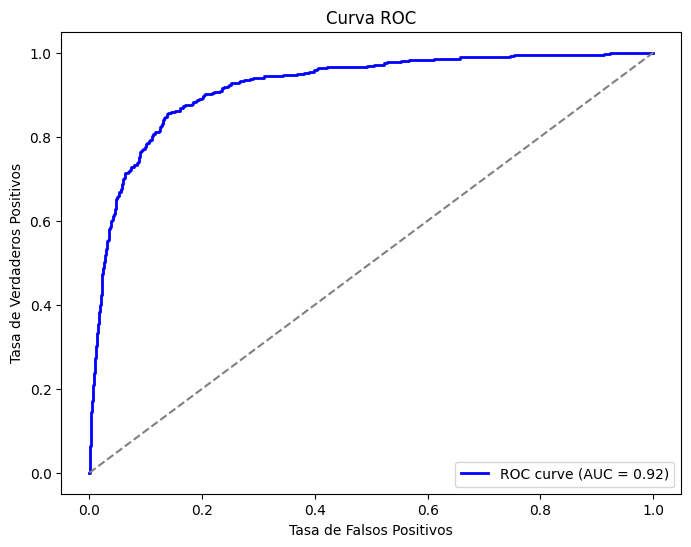

In [16]:
# Graficar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

#### A través de los datos obtenidos, se puede determinar con AUC (0.91) que el modelo logra separar las clases decentemente.

#### 6. Por último, se imprimen los coeficientes para poder dar una interpretación de su peso en el modelo.

In [17]:
coef_dict = dict(zip(features, model.coef_[0]))
print("\nCoeficientes del modelo de regresión logística:")
for feature, coef in coef_dict.items():
    print(f"{feature}: {coef:.4f}")


Coeficientes del modelo de regresión logística:
CO (ppm): 0.1905
NO2 (ppb): 0.6392
O3 (ppb): 0.4282
PM10 (µg/m3): 1.1500
PRS (mmHg): -0.2036
RAINF (mm/h): -0.3654
RH (%): 1.0177
SO2 (ppb): 0.1424
SR (kWh/m2): 0.2045
Temp (°C): -0.3363
WSR (km/h): 0.0352
WDR (°): -0.1012
Fecha: -0.8374
Hora: 0.0652


#### Se puede establecer que hay una relación positiva entre CO (ppm), NO2 (ppb), O3 (ppb), PM10 (µg/m3), RH (%), SO2 (ppb), SR (kWh/m2), WSR (km/h) y Hora, mientras que las demás variables contiente una relación negativa PRS (mmHg), RAINF (mm/h), Temp (°C), WDR (°) y Fecha. 

#### De las anteriores características, se describirá solo como las de mayor impacto afectan al cambio logarítmico de las probabilides. La de mayor impacto es PM10 (con 1.17), lo que representa las partículas de menos de 10 micrómetros, y que establece que cada aumento de 1 µg/m³ en PM10 casi triplica la probabilidad (𝑒^1.1729 ≈ 3.23). Después se tiene RH (%) con 1.0713, el cual representa la humedad relativa, y que se interpreta como cada aumento del 1% en RH más, dobla la probabilidad de un aire más dañino (𝑒^1.0713 ≈ 2.92). Igualmente, se tiene NO2 (0.65), NO2 en 1 ppb incrementa las probabilidades de aire dañino en un 𝑒^0.6566 ≈ 1.93 (93% más probabilidad). 

#### En conclusión, con base a los resultados del modelo anterior, es necesario para reducir la contaminación, monitorear y controlar NO2, PM10 y humedad relativa, ya que son los factores que aumentan más significativamente la probabilidad de tener un aire dañino con el model de regresión logística generado.